In [2]:
# Import of the required libraries
import georinex as gr
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import datetime as datetime
from datetime import datetime as dtt
import matplotlib.dates as mdates
from matplotlib.dates import DateFormatter

# Import of the software's modules
import functions as fn
import transformations as trf
import pointPositioning as pp
import RINEXreader 

In [3]:
param_file = 'parameters.txt'
file = open(param_file, 'r')
p = file.read().split('\n')

# Definition of the paths to the RINEX files
nav_path = p[0]
obs_path = p[1]
eph_path = p[2]
cutoff = int(p[3])

# Load with georinex library of nav and obs rinex info

In [4]:
# Loading of GPS navigation parameters from NAV RINEX
param_gps = gr.load(nav_path)
df_gps = param_gps.to_dataframe()
df_gps = ((df_gps.dropna()).sort_values(by=['time'], ascending = True)).reset_index()
# Corrupted timestamps are corrected
df_gps = fn.fixTime(df_gps)

# Loading of GPS code observations in a DataSet
obs = gr.load(obs_path, use = 'G')

data = df_gps['time'][0]

C:\git\pointPositioning\pointPositioning\functions.py:19: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df['time'][i] = t


In [5]:
# Definition of time range in which we want to carry out the analysis (get Satellite position, velocity and clockoffset and
# perform Point Positioning)
time_range = []

START = df_gps['time'].min()
END = dtt.strptime('2021-05-26 00:20:00', '%Y-%m-%d %H:%M:%S')
t = START
while t <= END:
    time_range.append(t)
    t = t + datetime.timedelta(minutes=5)
mask_par = df_gps['time'] <= END
df_gps = df_gps[mask_par].reset_index().drop(columns=['index'])
    
# List of the timestamps of the available observation (we can perform Point Positioning only when we have sufficient 
# code observations)
time_obs = obs.time.to_dataframe()['time'].tolist()

# Satellites positions, velocities and clock offsets

In [6]:
# Definition of the empty DataFrame that will contain the results
satellites = pd.DataFrame(columns = ['time', 'sv', 'xs', 'ys', 'zs', 'xs_dot', 'ys_dot', 'zs_dot', 'ts', 'C1'])

for w in time_range:
    # The list of satellites, whose parameter we want to estimate, is obtained from the available observations:
    # for each instant of time in time_range we select the in-view satellite
    # their position, velocity and clock offset are the computed
    if w in time_obs:
        obs_tk = (obs.sel(time = w)).to_dataframe().reset_index()
        obs_tk = obs_tk[['time', 'sv', 'P1']].dropna().reset_index()
        available_sat = (obs_tk['sv']).to_list()
        if len(available_sat) > 0:
            for sv_i in available_sat:
                # Every satellite in view at the considered epoch is associated with the parameter slot 
                # to which it belongs through the getPar function
                sat_par = fn.getPar(sv_i, w, df_gps)
                # If the navigation parameters are available:
                if type(sat_par) == pd.core.frame.DataFrame:
                    sat = fn.satPosVel(sat_par).reset_index()
                    sat = sat.merge(obs_tk, on = ['sv', 'time'], how = 'left')
                    satellites = satellites.append(sat)
        
satellites = satellites.reset_index()
satellites = satellites[['time', 'sv', 'xs', 'ys', 'zs', 'xs_dot', 'ys_dot', 'zs_dot', 'ts', 'P1']]

print(satellites)

                  time   sv            xs            ys            zs  \
0  2021-05-26 00:00:00  G02  2.135798e+07 -1.473658e+07  6.439559e+06   
1  2021-05-26 00:00:00  G05  6.689723e+06 -1.392794e+07  2.143672e+07   
2  2021-05-26 00:00:00  G06  2.543621e+07 -5.896490e+06 -4.987166e+06   
3  2021-05-26 00:00:00  G07  1.425396e+07  1.027658e+07  2.040488e+07   
4  2021-05-26 00:00:00  G09  8.367914e+06  1.962441e+07  1.574966e+07   
5  2021-05-26 00:00:00  G13  1.316160e+07 -2.095408e+07  9.332382e+06   
6  2021-05-26 00:00:00  G14  2.223440e+07  1.089473e+07 -9.666531e+06   
7  2021-05-26 00:00:00  G20 -6.286587e+05 -1.750810e+07  1.999084e+07   
8  2021-05-26 00:00:00  G30  2.371831e+07  1.297798e+06  1.218316e+07   
9  2021-05-26 00:05:00  G02  2.157316e+07 -1.475514e+07  5.522321e+06   
10 2021-05-26 00:05:00  G05  7.361410e+06 -1.343968e+07  2.153280e+07   
11 2021-05-26 00:05:00  G06  2.526201e+07 -5.766378e+06 -5.923931e+06   
12 2021-05-26 00:05:00  G07  1.355345e+07  1.056421

# Check on satellites' position and clock offsets

In [6]:
confronto = fn.checkSatPos(satellites, eph_path)

abs(computed_value - expected_value for ephemerides
Mean:
X:  0.7102071603815097
Y:  0.8826682459149096
Z:  0.7832794308248493
ts:  1.5553989445192885e-09
Max:
X:  1.4333764500916004
Y:  1.7611916828900576
Z:  2.549215259961784
ts:  2.763331089422399e-09


# Check on satellites' velocity

In [7]:
velocita = fn.checkSatVel(satellites, df_gps)

abs(computed_value - expected_value for velocities
Mean:
X:  0.26341583928571755
Y:  0.29895264642473823
Z:  0.4283584448295672
Max:
X:  0.5176153444942884
Y:  0.5357053792870374
Z:  0.6988966359126678


# Point Positioning

In [7]:
# Alpha and Beta paramethers for computing Ionosphere correction are read from nav RINEX through an apposite function
ionoParams = RINEXreader.getIonoParams(nav_path)
print('Inosphere parameters: ', ionoParams)

# Definition of the initial position of the receiver (from OBS RINEX)
R_0 = RINEXreader.getStartPos(obs_path)

# Performing of Point Positioning with the apposite function
results = pp.pointPositioning(satellites, R_0, ionoParams, cutoff)

print(results)

Inosphere parameters:  [[6.5193e-09, 2.2352e-08, -5.9605e-08, -1.1921e-07], [86016.0, 98304.0, -65536.0, -524290.0]]
2021-05-26 00:00:00 ok
2021-05-26 00:05:00 ok
2021-05-26 00:10:00 ok
2021-05-26 00:15:00 ok
2021-05-26 00:20:00 ok
   index            datetime            xr             yr            zr  \
0      0 2021-05-26 00:00:00  4.421977e+06  718516.621699  4.524918e+06   
1      0 2021-05-26 00:05:00  4.421977e+06  718516.693303  4.524918e+06   
2      0 2021-05-26 00:10:00  4.421976e+06  718516.628545  4.524917e+06   
3      0 2021-05-26 00:15:00  4.421976e+06  718516.851376  4.524918e+06   
4      0 2021-05-26 00:20:00  4.421975e+06  718516.422412  4.524917e+06   

        dtr in_view_sat  
0 -0.000392           9  
1 -0.000414           9  
2 -0.000435           9  
3 -0.000455           9  
4 -0.000475           9  


In [8]:
print('Statistical analysis on Point Positioning results:')
print('Mean values: ')
print('XR: ', results['xr'].mean())
print('YR: ', results['yr'].mean())
print('ZR: ', results['zr'].mean())
print('dtR: ', results['dtr'].mean())

print('Standard deviation: ')
print('XR: ', results['xr'].std())
print('YR: ', results['yr'].std())
print('ZR: ', results['zr'].std())
print('dtR: ', results['dtr'].std())

Statistical analysis on Point Positioning results:
Mean values: 
XR:  4421976.344847493
YR:  718516.6434672248
ZR:  4524917.758395143
dtR:  -0.0004341817565623052
Standard deviation: 
XR:  0.7828668159468775
YR:  0.1543304194060876
ZR:  0.4734072116993931
dtR:  3.27957908755505e-05


# Transformation in Local Cartesian

In [9]:
# Coordinates of the receiver, Milan Permanent Station, reference: SPIN3GNSS
P0_g = [45.478368630552694, 9.229212872263435, 191.12520962953568]
P0_cart = trf.geodToCart(45.478368630552694, 9.229212872263435, 191.12520962953568)

results_LC = pd.DataFrame()
results_LC['dx'] = results['xr'] - P0_cart[0]
results_LC['dy'] = results['yr'] - P0_cart[1]
results_LC['dz'] = results['zr'] - P0_cart[2]

E=[]
N=[]
U=[]

lat0 = trf.degToRad(P0_g[0])
lon0 = trf.degToRad(P0_g[1])

# Definition of the rotation matrix
R = np.array([ [-np.sin(lon0), np.cos(lon0), 0],
                [-np.sin(lat0)*np.cos(lon0), -np.sin(lat0)*np.sin(lon0), np.cos(lat0)],
                [np.cos(lat0)*np.cos(lon0), np.cos(lat0)*np.sin(lon0), np.sin(lat0)]
                ])

for i in range(len(results_LC)):
    delta_array_i = np.array([[results_LC['dx'][i]], [results_LC['dy'][i]], [results_LC['dz'][i]]])
    ENU =np.dot(R, delta_array_i)
    E.append(ENU[0][0])
    N.append(ENU[1][0])
    U.append(ENU[2][0])

results_LC['E'] = E
results_LC['N'] = N
results_LC['U'] = U
results_LC['time'] = results['datetime']
results_LC = results_LC.reset_index()

In [10]:
print('MEDIA ERRORI:')
print('Est: ', results_LC['E'].mean(), '\n',
      'Nord: ', results_LC['N'].mean(), '\n',
      'Quota: ', results_LC['U'].mean() )

print('DEVIAZIONE STANDARD:', '\n',
      'Est: ', results_LC['E'].std(), '\n',
      'Nord: ', results_LC['N'].std(), '\n',
      'Quota: ', results_LC['U'].std() )

print('Valori Massimi:', '\n',
      'Est: ', abs(results_LC['E']).max(), '\n',
      'Nord: ', abs(results_LC['N']).max(), '\n',
      'Quota: ', abs(results_LC['U']).max() )

MEDIA ERRORI:
Est:  -1.1557014013772453 
 Nord:  1.6202456271552215 
 Quota:  -4.833036439758981
DEVIAZIONE STANDARD: 
 Est:  0.16270387082252946 
 Nord:  0.24929316960400774 
 Quota:  0.8787451757830641
Valori Massimi: 
 Est:  1.3370888749480063 
 Nord:  1.9991793830111702 
 Quota:  5.892660951320849


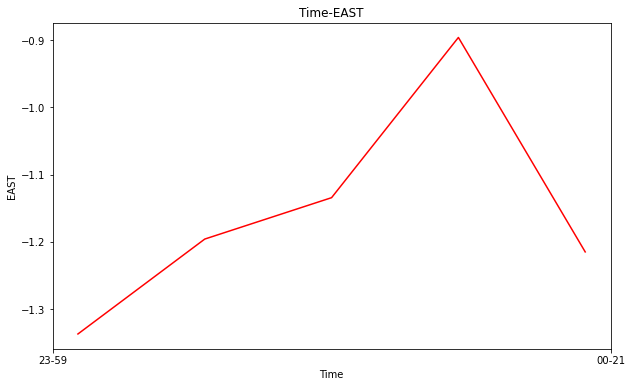

In [11]:
fig, ax = plt.subplots(figsize=(10,6))
ax.plot(results_LC['time'], results_LC['E'],
        '-',
        color='red')
ax.set(xlabel="Time", ylabel='EAST', title = 'Time-EAST')
ax.xaxis.set_major_locator(mdates.HourLocator(interval=2))
ax.xaxis.set_major_formatter(DateFormatter("%H-%M"))
plt.show()

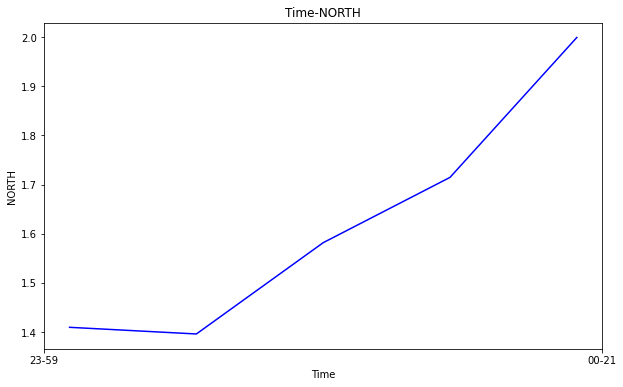

In [12]:
fig, ax = plt.subplots(figsize=(10,6))
ax.plot(results_LC['time'], results_LC['N'],
        '-',
        color='blue')
ax.set(xlabel="Time", ylabel='NORTH', title = 'Time-NORTH')
ax.xaxis.set_major_locator(mdates.HourLocator(interval=2))
ax.xaxis.set_major_formatter(DateFormatter("%H-%M"))
plt.show()

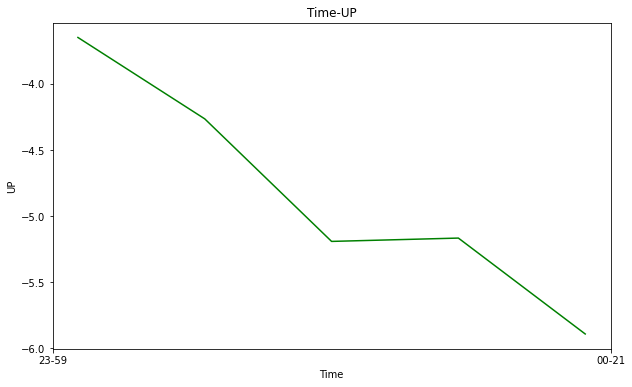

In [13]:
fig, ax = plt.subplots(figsize=(10,6))
ax.plot(results_LC['time'], results_LC['U'],
        '-',
        color='green')
ax.set(xlabel="Time", ylabel='UP', title = 'Time-UP')
ax.xaxis.set_major_locator(mdates.HourLocator(interval=2))
ax.xaxis.set_major_formatter(DateFormatter("%H-%M"))
plt.show()